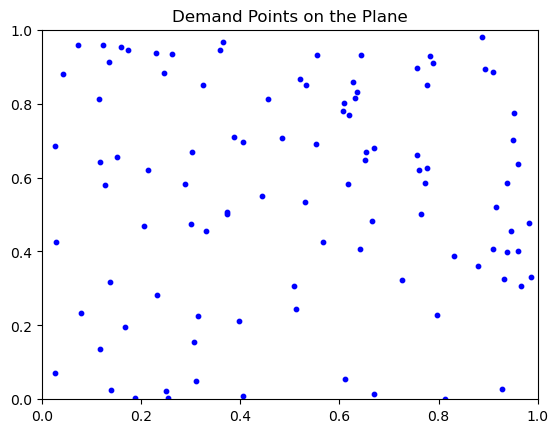

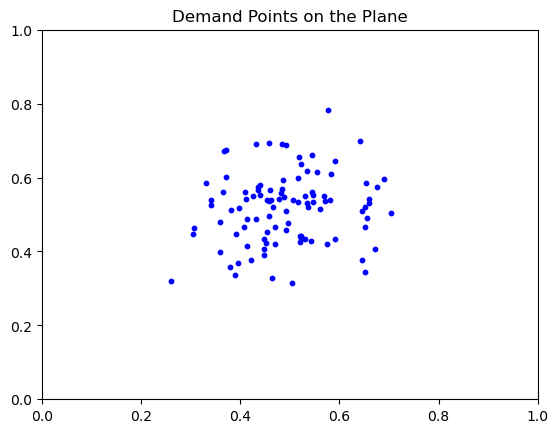

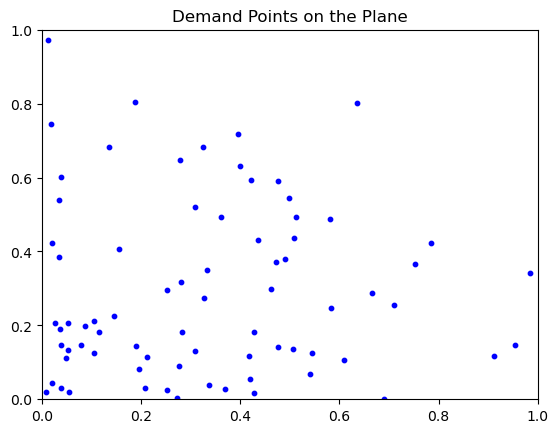

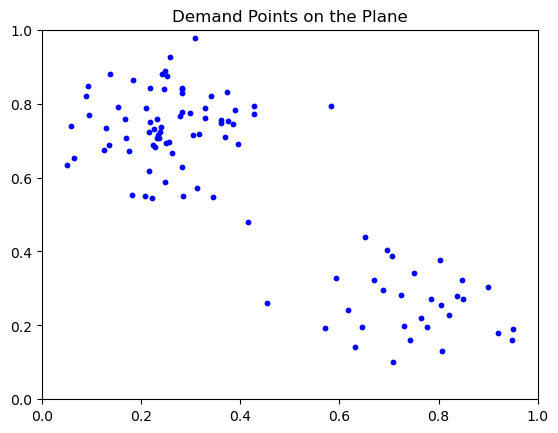

In [84]:
import numpy as np
import python_tsp as tsp
from python_tsp.distances import euclidean_distance_matrix
from python_tsp.heuristics import solve_tsp_local_search, solve_tsp_simulated_annealing
import matplotlib.pyplot as plt
from scipy import optimize, integrate


def plot_demand_points(demand_locations, region_magnitude):
    '''
    Plot the demand points
    '''
    plt.scatter(demand_locations[:, 0], demand_locations[:, 1], c='b', s=10)
    plt.xlim(0, region_magnitude)
    plt.ylim(0, region_magnitude)
    plt.title('Demand Points on the Plane')
    plt.show()

def plot_routes(locations, route, tsp_dis, wlk_dis=0):
    X, Y = locations[:, 0], locations[:, 1]
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.set_title('Optimized tour')
    ax.scatter(X, Y)
    distance = 0.0
    N = locations.shape[0]
    start_node = 0
    for i in range(N):
        start_pos = locations[start_node]
        next_node = route[i+1] if i < N-1 else route[0]
        end_pos = locations[next_node]
        ax.annotate("",
                xy=start_pos, xycoords='data',
                xytext=end_pos, textcoords='data',
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="arc3"))
        distance += np.linalg.norm(end_pos - start_pos)
        start_node = next_node
    textstr = "N nodes: %d\nTotal TSP length: %.3f\nTotal Wlk length: %.3f\nTotal length: %.3f" % (N, tsp_dis, wlk_dis, tsp_dis+wlk_dis)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10, # Textbox
        verticalalignment='top', bbox=props)
    return ax


def BHH_approx(f, N, magnitude):
    '''
    Approximate the TSP length using BHH approximation
    
    Parameters:
    f: demand probablity density function (pdf) with two arguments
        The demand density function
    N: int
        The number of sampled demand points
    '''
    integrand = lambda y, x: np.sqrt(f(x, y))
    beta = 2287/(np.sqrt(214) * 210)
    result = integrate.dblquad(integrand, 0, magnitude, lambda x: 0, lambda x: magnitude)
    area, error = result
    return beta*np.sqrt(N)*area

def demand_location_generator(demand_size, region_magnitude, demand_distribution, args):
    '''
    Use numpy to generate the demand locations if demand_distribution is a string speciyfing the distribution name inlcuding
    uniform, gaussian, exponential, etc.

    Otherwise use the demand_distribution function to generate the demand locations
    '''
    case_map = ['uniform', 'gaussian','exponential', 'gaussian_mix']
    
    if isinstance(demand_distribution, str):
        if demand_distribution in case_map:
            if demand_distribution == 'uniform':
                return np.random.uniform(0, region_magnitude, (demand_size, 2))
            elif demand_distribution == 'gaussian':
                mean = args[0]
                std = args[1]
                return np.random.multivariate_normal(mean, std, demand_size)
            elif demand_distribution == 'exponential':
                rate = args[0]
                return np.random.exponential(rate, (demand_size, 2))
            elif demand_distribution == 'gaussian_mix':
                shares = args[0]
                num_gaussians = len(shares)
                demand_locations = np.array([])
                for i in range(num_gaussians):
                    paramsi = args[i+1]
                    meani = paramsi[0]
                    stdi = paramsi[1]
                    demand_sizei = int(demand_size*shares[i])
                    demand_locationsi = np.random.multivariate_normal(meani, stdi, demand_sizei)
                    demand_locations = np.append(demand_locations, demand_locationsi)
                return demand_locations.reshape(-1, 2)

        else:
            raise ValueError('Invalid string distribution name')

    # Otherwise use the user-input demand_distribution function
    demand_locations = np.array([])
    while demand_locations.size < demand_size:
        x = np.random.uniform(0, region_magnitude)
        y = np.random.uniform(0, region_magnitude)
        u = np.random.uniform(0, 1)
        if u < demand_distribution(x, y):
            demand_locations = np.append(demand_locations, [x, y])
    return demand_locations.reshape(-1, 2)

demand_size, region_magnitude = 100, 1
demand_locations = demand_location_generator(demand_size, region_magnitude, 'uniform', None)
plot_demand_points(demand_locations, region_magnitude)
demand_locations = demand_location_generator(demand_size, region_magnitude, 'gaussian', args=[np.array([0.5, 0.5]), np.array([[0.01, 0], [0, 0.01]])])
plot_demand_points(demand_locations, region_magnitude)
demand_locations = demand_location_generator(demand_size, region_magnitude, 'exponential', args=[0.5])
plot_demand_points(demand_locations, region_magnitude)
demand_locations = demand_location_generator(demand_size, region_magnitude, 'gaussian_mix', args=[[0.7, 0.3], [np.array([0.25, 0.75]), np.array([[0.01, 0], [0, 0.01]])], [np.array([0.75, 0.25]), np.array([[0.01, 0], [0, 0.01]])]])
plot_demand_points(demand_locations, region_magnitude)

# Uniform distribution

BHH approximation:  7.44457626240669
True TSP length:  8.136788213321264


/Users/miaoyidi/miniconda3/envs/HCT/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


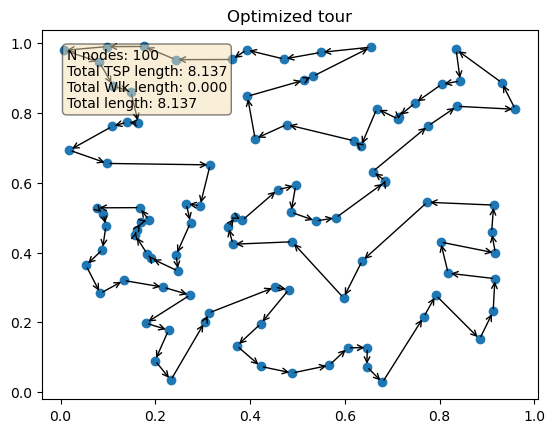

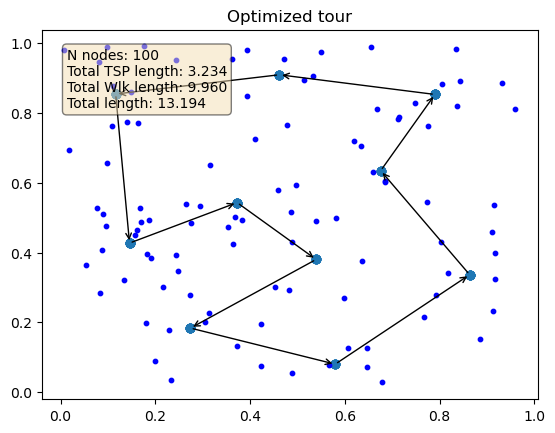

In [85]:
from sklearn.cluster import KMeans

demand_size, region_magnitude = 100, 1

def density_func(x, y, region_magnitude):
    return 1/(region_magnitude**2)

# On-demand
demand_locations = demand_location_generator(demand_size, region_magnitude, 'uniform', None)
distance_matrix = euclidean_distance_matrix(demand_locations)
BHH_TSP_length = BHH_approx(lambda x, y: density_func(x, y, region_magnitude), demand_size, region_magnitude)
true_route, true_dis = solve_tsp_simulated_annealing(distance_matrix)
print('BHH approximation: ', BHH_TSP_length)
print('True TSP length: ', true_dis)
plot_routes(demand_locations, true_route, true_dis)

# Fixed-route
num_fixed_stops = 10
kmeans = KMeans(n_clusters=num_fixed_stops, random_state=0).fit(demand_locations)
labels, centers = kmeans.labels_, kmeans.cluster_centers_
centers_ctgr = np.array([centers[i] for i in labels])
distance_matrix = euclidean_distance_matrix(centers_ctgr)
total_wlk_dis = np.sum(np.linalg.norm(centers_ctgr - demand_locations, axis=1))
stop_route, stop_dis = solve_tsp_simulated_annealing(distance_matrix)
ax = plot_routes(centers_ctgr, stop_route, stop_dis, total_wlk_dis)
ax.scatter(demand_locations[:, 0], demand_locations[:, 1], c='b', s=10)

# Gaussian

True TSP length:  3.750327760810907


/Users/miaoyidi/miniconda3/envs/HCT/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


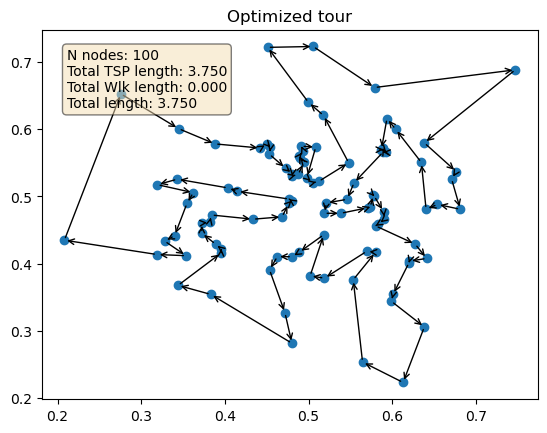

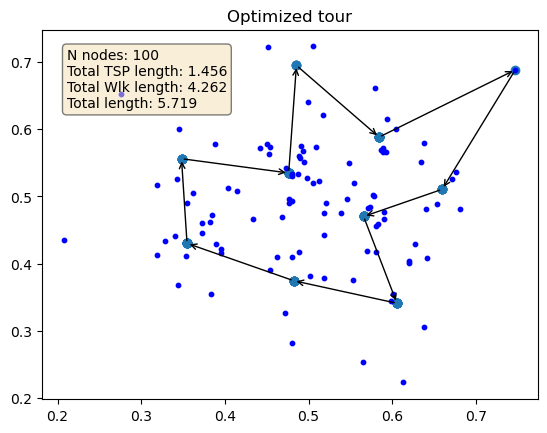

In [87]:
demand_size, region_magnitude = 100, 1
mean, std = np.array([0.5, 0.5]), np.array([[0.01, 0], [0, 0.01]])

def density_func(x, y, region_magnitude, mean, std):
    return 1/(2*np.pi*np.linalg.det(std)) * np.exp(-0.5*np.dot(np.dot(np.array([x-mean, y-mean]), np.linalg.inv(std)), np.array([x-mean, y-mean])))

# On-demand
demand_locations = demand_location_generator(demand_size, region_magnitude, 'gaussian', args=[mean, std])
distance_matrix = euclidean_distance_matrix(demand_locations)
# BHH_TSP_length = BHH_approx(lambda x, y: density_func(x, y, region_magnitude, mean, std), demand_size, region_magnitude)
true_route, true_dis = solve_tsp_simulated_annealing(distance_matrix)
# print('BHH approximation: ', BHH_TSP_length)
print('True TSP length: ', true_dis)
plot_routes(demand_locations, true_route, true_dis)

# Fixed-route
num_fixed_stops = 10
kmeans = KMeans(n_clusters=num_fixed_stops, random_state=0).fit(demand_locations)
labels, centers = kmeans.labels_, kmeans.cluster_centers_
centers_ctgr = np.array([centers[i] for i in labels])
distance_matrix = euclidean_distance_matrix(centers_ctgr)
total_wlk_dis = np.sum(np.linalg.norm(centers_ctgr - demand_locations, axis=1))
stop_route, stop_dis = solve_tsp_simulated_annealing(distance_matrix)
ax = plot_routes(centers_ctgr, stop_route, stop_dis, total_wlk_dis)
ax.scatter(demand_locations[:, 0], demand_locations[:, 1], c='b', s=10)

# Exponential

True TSP length:  14.74306192378323


/Users/miaoyidi/miniconda3/envs/HCT/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


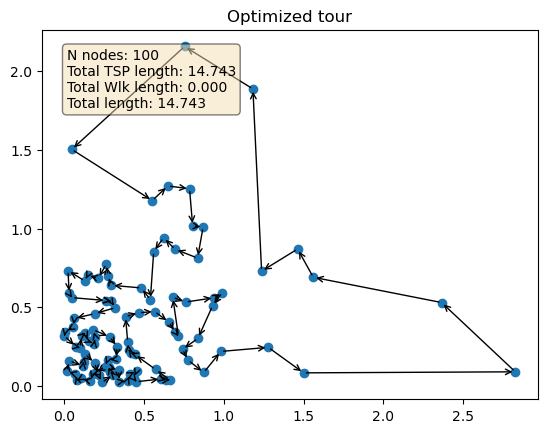

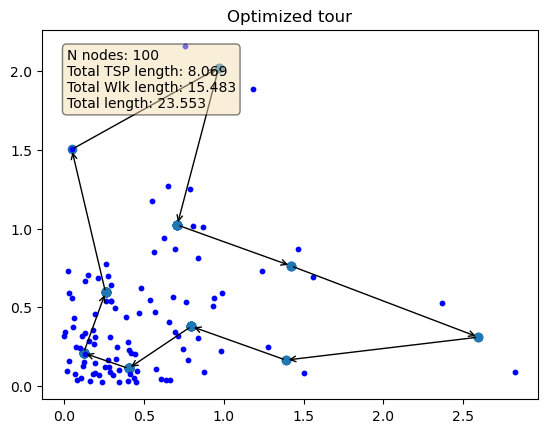

In [89]:
demand_size, region_magnitude = 100, 1
rate = 0.5
def density_func(x, y, region_magnitude, rate):
    return rate*np.exp(-rate*x)*rate*np.exp(-rate*y)

# On-demand
demand_locations = demand_location_generator(demand_size, region_magnitude, 'exponential', args=[rate])
distance_matrix = euclidean_distance_matrix(demand_locations)
# BHH_TSP_length = BHH_approx(lambda x, y: density_func(x, y, region_magnitude, mean, std), demand_size, region_magnitude)
true_route, true_dis = solve_tsp_simulated_annealing(distance_matrix)
# print('BHH approximation: ', BHH_TSP_length)
print('True TSP length: ', true_dis)
plot_routes(demand_locations, true_route, true_dis)

# Fixed-route
num_fixed_stops = 10
kmeans = KMeans(n_clusters=num_fixed_stops, random_state=0).fit(demand_locations)
labels, centers = kmeans.labels_, kmeans.cluster_centers_
centers_ctgr = np.array([centers[i] for i in labels])
distance_matrix = euclidean_distance_matrix(centers_ctgr)
total_wlk_dis = np.sum(np.linalg.norm(centers_ctgr - demand_locations, axis=1))
stop_route, stop_dis = solve_tsp_simulated_annealing(distance_matrix)
ax = plot_routes(centers_ctgr, stop_route, stop_dis, total_wlk_dis)
ax.scatter(demand_locations[:, 0], demand_locations[:, 1], c='b', s=10)


# Gaussian-Mix

True TSP length:  4.272517021530143


/Users/miaoyidi/miniconda3/envs/HCT/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


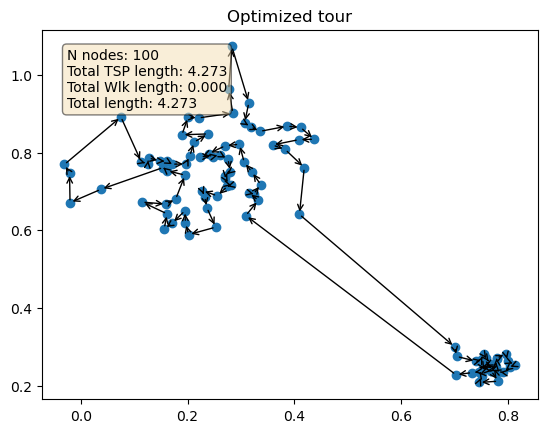

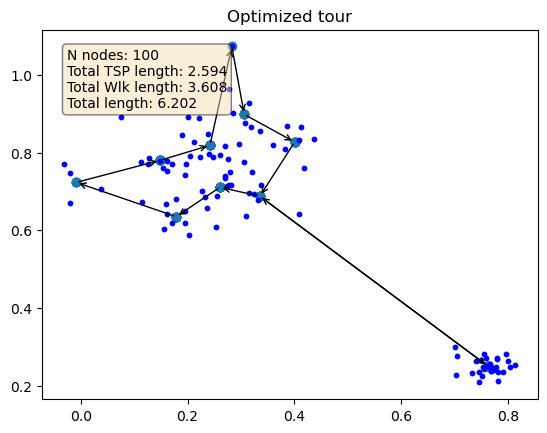

In [96]:
demand_size, region_magnitude = 100, 1
shares = [0.7, 0.3]
means = [np.array([0.25, 0.75]), np.array([0.75, 0.25])]
stds = [np.array([[0.01, 0], [0, 0.01]]), np.array([[0.001, 0], [0, 0.001]])]

def density_func(x, y, region_magnitude, mean, std):
    return 1/(2*np.pi*np.linalg.det(std)) * np.exp(-0.5*np.dot(np.dot(np.array([x-mean, y-mean]), np.linalg.inv(std)), np.array([x-mean, y-mean])))

# On-demand
demand_locations = demand_location_generator(demand_size, region_magnitude, 'gaussian_mix', args=[shares, [means[0], stds[0]], [means[1], stds[1]]])
distance_matrix = euclidean_distance_matrix(demand_locations)
# BHH_TSP_length = BHH_approx(lambda x, y: density_func(x, y, region_magnitude, mean, std), demand_size, region_magnitude)
true_route, true_dis = solve_tsp_simulated_annealing(distance_matrix)
# print('BHH approximation: ', BHH_TSP_length)
print('True TSP length: ', true_dis)
plot_routes(demand_locations, true_route, true_dis)

# Fixed-route
num_fixed_stops = 10
kmeans = KMeans(n_clusters=num_fixed_stops, random_state=0).fit(demand_locations)
labels, centers = kmeans.labels_, kmeans.cluster_centers_
centers_ctgr = np.array([centers[i] for i in labels])
distance_matrix = euclidean_distance_matrix(centers_ctgr)
total_wlk_dis = np.sum(np.linalg.norm(centers_ctgr - demand_locations, axis=1))
stop_route, stop_dis = solve_tsp_simulated_annealing(distance_matrix)
ax = plot_routes(centers_ctgr, stop_route, stop_dis, total_wlk_dis)
ax.scatter(demand_locations[:, 0], demand_locations[:, 1], c='b', s=10)

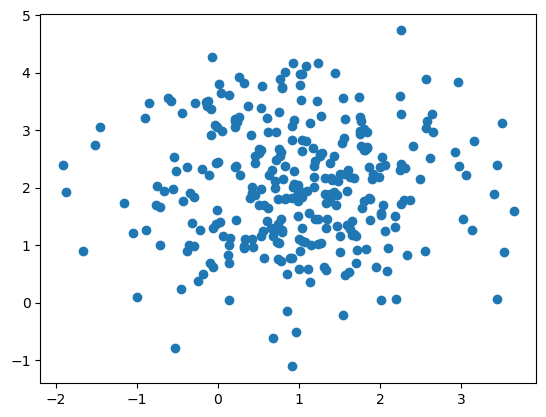

In [11]:
normal_locations = np.random.multivariate_normal(np.array([1, 2]), cov = np.eye(2), size=(size,))
normal_X, normal_Y = normal_locations[:, 0], normal_locations[:, 1]
normal_distance_matrix = euclidean_distance_matrix(normal_locations)
noraml_route, normal_dis = solve_tsp_simulated_annealing(normal_distance_matrix)
plt.scatter(normal_X, normal_Y)

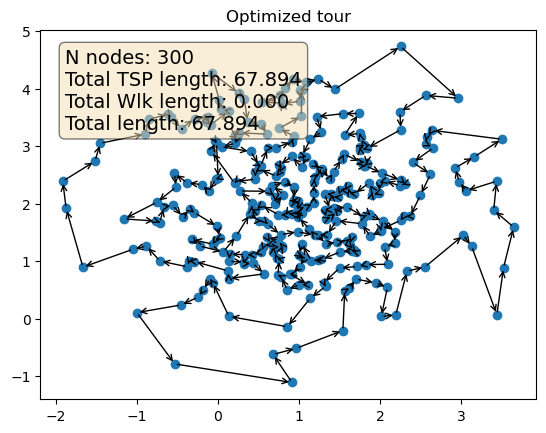

In [12]:
ax = plot_routes(normal_X, normal_Y, normal_locations, noraml_route, normal_dis)
ax.scatter(normal_X, normal_Y)

d:\anaconda3\envs\py39\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


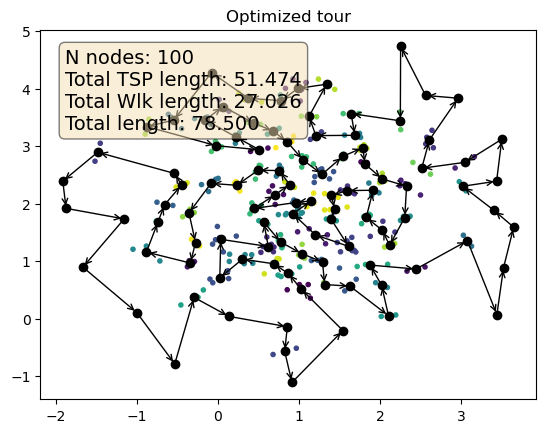

In [19]:
normal_clusters = kmeans.fit(normal_locations)
labels, centers = normal_clusters.labels_, normal_clusters.cluster_centers_
center_X, center_Y = centers[:, 0], centers[:, 1]
# plt.scatter(center_X, center_Y, c='black')
# plt.scatter(X, Y,s=9, c=labels)
center_distance_matrix = euclidean_distance_matrix(centers)
center_route, center_dis = solve_tsp_simulated_annealing(center_distance_matrix)
center_ctgr = np.array([centers[i] for i in labels])
wlk_dis = np.sum(np.linalg.norm(normal_locations - center_ctgr, axis=1))
ax = plot_routes(center_X, center_Y, centers, center_route, center_dis, wlk_dis)
ax.scatter(normal_X, normal_Y, s=9, c=labels)
ax.scatter(center_X, center_Y, c='black')

In [8]:
import numpy as np

arr = np.array([1,2,3])
for i in arr:
    print(i)

np.floor(arr*0.3)
np.arange(0, 1, 0.1)

1
2
3


array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])